At least 1% useful volume with labels that are not 0
we use optimizzer Adam W

In [ ]:
# Install required packages
!pip install split-folders

import os
import numpy as np
import nibabel as nib
import glob
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tifffile import imsave
from google.colab import drive
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import splitfolders # Added import

# Mount Google Drive
drive.mount('/content/drive')

# Path to data in Google Drive
data_path = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

Mounted at /content/drive


In [ ]:
'''
#------------------------------------------------------------------------------
# Data Preprocessing (cropping, merging, saving npy files)
#------------------------------------------------------------------------------

scaler = MinMaxScaler()

# Define output directories
output_dir = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test4/images/'
output_dir1 = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test4/masks/'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir1, exist_ok=True)

# File paths
t1_list = glob.glob(os.path.join(data_path, "*/*t1.nii"))
t2_list = glob.glob(os.path.join(data_path, "*/*t2.nii"))
t1ce_list = glob.glob(os.path.join(data_path, "*/*t1ce.nii"))
flair_list = glob.glob(os.path.join(data_path, "*/*flair.nii"))
mask_list = glob.glob(os.path.join(data_path, "*/*seg.nii"))


# Iterate through the image lists and process each patient's data
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)

    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))


    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save(os.path.join(output_dir, f"image_{img}.npy"), temp_combined_image)
        np.save(os.path.join(output_dir1, f"mask_{img}.npy"), temp_mask)

    else:
        print("I am useless")


#-----------------------------------------------------------------------------
'''

'\n#------------------------------------------------------------------------------\n# Data Preprocessing (cropping, merging, saving npy files)\n#------------------------------------------------------------------------------\n\nscaler = MinMaxScaler()\n\n# Define output directories\noutput_dir = \'/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test4/images/\'\noutput_dir1 = \'/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test4/masks/\'\nos.makedirs(output_dir, exist_ok=True)\nos.makedirs(output_dir1, exist_ok=True)\n\n# File paths\nt1_list = glob.glob(os.path.join(data_path, "*/*t1.nii"))\nt2_list = glob.glob(os.path.join(data_path, "*/*t2.nii"))\nt1ce_list = glob.glob(os.path.join(data_path, "*/*t1ce.nii"))\nflair_list = glob.glob(os.path.join(data_path, "*/*flair.nii"))\nmask_list = glob.glob(os.path.join(data_path, "*/*seg.nii"))\n\n\n# Iterate through the image lists and process each patient\'s data\nfor img in range(len(t2_list)):   #Usi

In [ ]:
'''
# Data Splitting
#------------------------------------------------------------------------------

input_folder = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test4/'
output_folder = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test44/'

# Split with a ratio.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

#------------------------------------------------------------------------------
'''

"\n# Data Splitting\n#------------------------------------------------------------------------------\n\ninput_folder = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test4/'\noutput_folder = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test44/'\n\n# Split with a ratio.\nsplitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)\n\n#------------------------------------------------------------------------------\n"

In [ ]:
# Data Generator
#------------------------------------------------------------------------------

# Define directories for train and mask images
train_img_dir = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test44/train/images/'
train_mask_dir = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test44/train/masks/'
val_img_dir = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test44/val/images/'
val_mask_dir = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test44/val/masks/'

# Create image_mask_generator function
def image_mask_generator(img_dir, mask_dir, batch_size, n_classes=4):
    image_filenames = [f for f in os.listdir(img_dir) if f.endswith('.npy')]
    num_samples = len(image_filenames)

    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < num_samples:
            X_batch = [] # Changed from image_batch to X_batch for clarity
            y_batch = [] # Changed from mask_batch to y_batch for clarity

            for i in range(batch_start, min(batch_end, num_samples)):
                image_path = os.path.join(img_dir, image_filenames[i])
                mask_path = os.path.join(mask_dir, image_filenames[i].replace('image', 'mask'))

                image = np.load(image_path)
                mask = np.load(mask_path)

                # One-hot encode the mask
                mask = to_categorical(mask, num_classes=n_classes) #one-hot encoding the mask

                X_batch.append(image) # Changed from image_batch.append(image) to X_batch.append(image)
                y_batch.append(mask) # Changed from mask_batch.append(mask) to y_batch.append(mask)

            yield np.array(X_batch), np.array(y_batch) # Changed yield statement to use X_batch and y_batch

            batch_start += batch_size
            batch_end += batch_size

# Test the generator
batch_size = 2
train_img_datagen = image_mask_generator(train_img_dir, train_mask_dir, batch_size)
val_img_datagen = image_mask_generator(val_img_dir, val_mask_dir, batch_size) # Added val_img_datagen

for i in range(2):  # Get 2 batches
    image_batch, mask_batch = next(train_img_datagen)
    print(f"Batch {i+1}:")
    print("Image batch shape:", image_batch.shape)
    print("Mask batch shape:", mask_batch.shape)

#------------------------------------------------------------------------------

Batch 1:
Image batch shape: (2, 128, 128, 128, 4)
Mask batch shape: (2, 128, 128, 128, 4)
Batch 2:
Image batch shape: (2, 128, 128, 128, 4)
Mask batch shape: (2, 128, 128, 128, 4)


In [ ]:
# 3D U-NET Model
#------------------------------------------------------------------------------
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_DEPTH = 128
IMG_CHANNELS = 4
N_CLASSES = 4 # Added N_CLASSES = 4 to use later in the model

def create_3d_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS), n_classes=N_CLASSES): # Added n_classes parameter
    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    conv1 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    # Bottleneck
    conv_bottleneck = tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv_bottleneck = tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv_bottleneck)

    # Expanding Path
    up1 = tf.keras.layers.Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv_bottleneck)
    merge1 = tf.keras.layers.concatenate([up1, conv2], axis=4)
    conv3 = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(merge1)
    conv3 = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv3)

    up2 = tf.keras.layers.Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv3)
    merge2 = tf.keras.layers.concatenate([up2, conv1], axis=4)
    conv4 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(merge2)
    conv4 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv4)

    # Output Layer
    outputs = tf.keras.layers.Conv3D(n_classes, (1, 1, 1), activation='softmax')(conv4)  # n_classes

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage:
model = create_3d_unet_model()
model.summary()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])


#------------------------------------------------------------------------------

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │          3,488 │ input_layer[0][0]      │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │         27,680 │ conv3d[0][0]           │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 32) │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 64) │         55,360 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 64) │        110,656 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 64) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32,     │        221,312 │ max_pooling3d_1[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 32,     │        442,496 │ conv3d_4[0][0]         │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_transpose          │ (None, 64, 64, 64, 64) │         65,600 │ conv3d_5[0][0]         │
│ (Conv3DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 64,     │              0 │ conv3d_transpose[0][0… │
│                           │ 128)                   │                │ conv3d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 64, 64, 64, 64) │        221,248 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_7 (Conv3D)         │ (None, 64, 64, 64, 64) │        110,656 │ conv3d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_transpose_1        │ (None, 128, 128, 128,  │         16,416 │ conv3d_7[0][0]         │
│ (Conv3DTranspose)         │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1        

 Total params: 1,358,052 (5.18 MB)

 Trainable params: 1,358,052 (5.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model Training
#------------------------------------------------------------------------------

# Training parameters
batch_size = 2 # Added batch_size declaration
steps_per_epoch = len(os.listdir(train_img_dir)) // batch_size
val_steps_per_epoch = len(os.listdir(val_img_dir)) // batch_size # Added validation steps per epoch
epochs = 100  # Adjust as needed


# Train the model
history = model.fit(image_mask_generator(train_img_dir, train_mask_dir, batch_size, N_CLASSES), # Changed to use the generator with its parameters
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=image_mask_generator(val_img_dir, val_mask_dir, batch_size, N_CLASSES), # Added validation_data
                    validation_steps=val_steps_per_epoch) #Added validation_steps



# %%
# prompt: save this model in drive

# Save the model to Google Drive
model.save('/content/drive/MyDrive/brats_3d_u_net.h5')

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 623ms/step - accuracy: 0.9953 - loss: 0.0112 - val_accuracy: 0.9954 - val_loss: 0.0112
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 590ms/step - accuracy: 0.9953 - loss: 0.0112 - val_accuracy: 0.9952 - val_loss: 0.0114
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 543ms/step - accuracy: 0.9953 - loss: 0.0112 - val_accuracy: 0.9945 - val_loss: 0.0135
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.9951 - loss: 0.0119 - val_accuracy: 0.9954 - val_loss: 0.0111
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 490ms/step - accuracy: 0.9954 - loss: 0.0110 - val_accuracy: 0.9954 - val_loss: 0.0110
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 489ms/step - accuracy: 0.9954 - loss: 0.0111 - val_accuracy: 0.9954 - val_loss: 0.0111
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accuracy: 0.9952 - loss: 0.0114 - val_accuracy: 0.9954 - val_loss: 0.0109
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 483ms/step - accuracy: 0.9955 - loss: 0.0109 - 

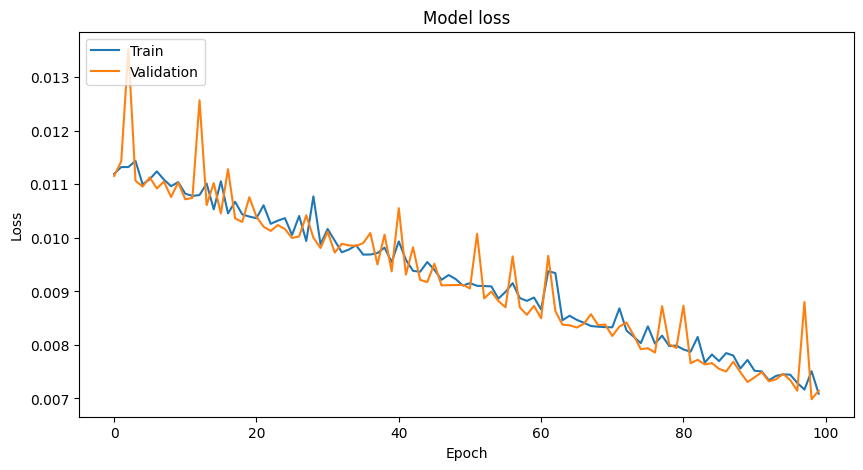

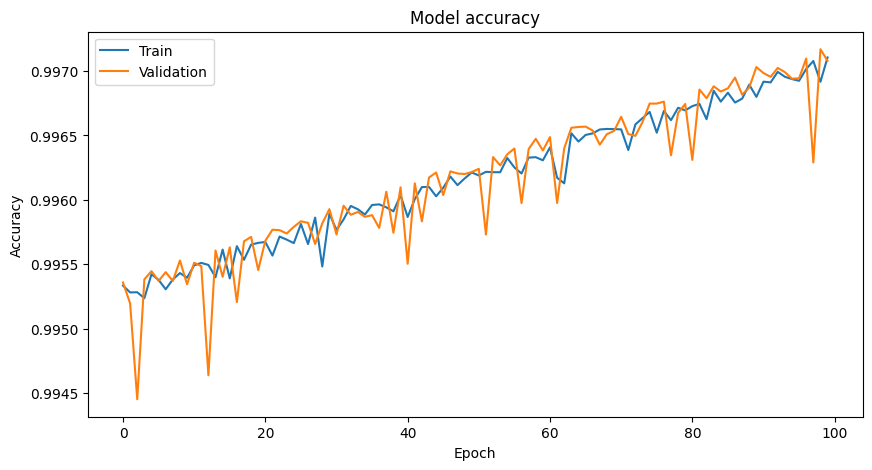

In [ ]:
# Plot Training and Validation Accuracy
# Visualize the training process by plotting loss and accuracy (or IoU) over epochs

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
#check if val_loss is in history
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
#check if val_accuracy is in history
if 'val_accuracy' in history.history:
  plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
my_model = tf.keras.models.load_model('/content/drive/MyDrive/brats_3d_u_net.h5', compile=False) # load without compiling



In [ ]:
# Define paths for test data and output predictions
test_img_dir = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test11/val/images/' # Update with your test image directory
pred_dir = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/predictions11/' # Update with your prediction output directory
os.makedirs(pred_dir, exist_ok=True)  # Ensure output directory exists

# Load the trained model
#model = tf.keras.models.load_model('/content/drive/MyDrive/brats_3d_unet.h5') #remove this line, already loaded
model = my_model #reassign the model

# Function to predict masks for a batch of test images
def predict_masks(test_img_dir, model, pred_dir):
    image_filenames = [f for f in os.listdir(test_img_dir) if f.endswith('.npy')]
    num_samples = len(image_filenames)

    for i in range(num_samples):
        image_path = os.path.join(test_img_dir, image_filenames[i])
        image = np.load(image_path)
        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Make prediction
        pred_mask = model.predict(image)

        # Get the class with the highest probability (argmax)
        pred_mask = np.argmax(pred_mask, axis=-1)

        # Save the predicted mask
        pred_mask_path = os.path.join(pred_dir, image_filenames[i].replace('image', 'predicted_mask'))
        np.save(pred_mask_path, pred_mask)

# Make predictions for test images

predict_masks(test_img_dir, model, pred_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Mounted at /content/drive
Model loaded successfully.
Image and mask for image number 37 loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
Prediction completed.


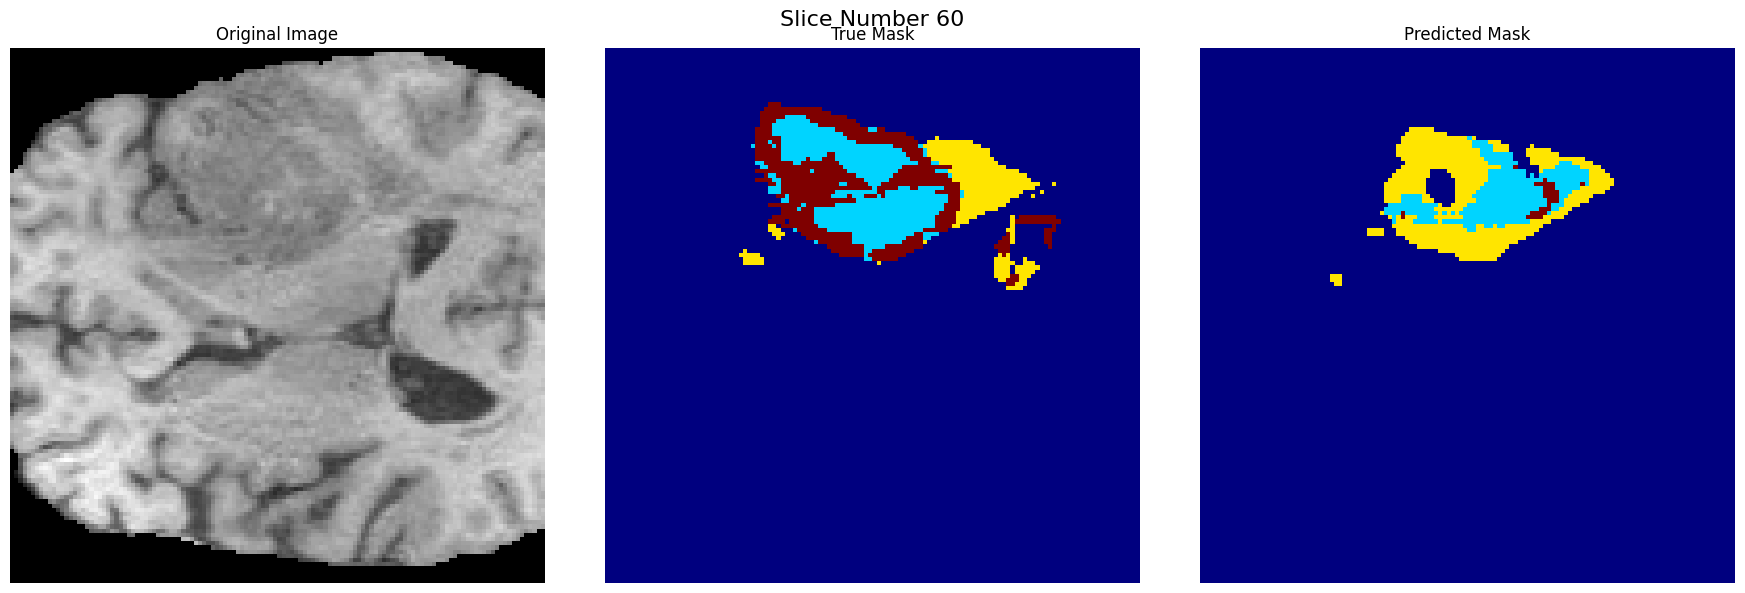

In [ ]:
# Mount Google Drive (if not already mounted)
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Load the model ---
model_path = '/content/drive/MyDrive/brats_3d_u_net.h5'
try:
    model = tf.keras.models.load_model(model_path, compile=False)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --- Load Image and Mask ---
img_num = 37
test_img_path = (
    "/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test11/val/images/image_"
    + str(img_num)
    + ".npy"
)
test_mask_path = (
    "/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test11/val/masks/mask_"
    + str(img_num)
    + ".npy"
)

try:
    test_img = np.load(test_img_path)
    test_mask = np.load(test_mask_path)
    print(f"Image and mask for image number {img_num} loaded successfully.")
except Exception as e:
    print(f"Error loading image or mask: {e}")
    exit()

# --- Preprocess the Image ---
# Expand dimensions to match model input (add batch dimension)
input_img = np.expand_dims(test_img, axis=0)

# --- Make Prediction ---
try:
    predicted_mask = model.predict(input_img)
    print("Prediction completed.")
except Exception as e:
    print(f"Error during prediction: {e}")
    exit()

# --- Post-process the Prediction ---
# Get the class with the highest probability (argmax)
predicted_mask = np.argmax(predicted_mask, axis=-1)
# Remove the batch dimension
predicted_mask = np.squeeze(predicted_mask, axis=0)

# --- Visualize Results ---
def display_comparison(original_image, true_mask, predicted_mask, slice_num=60):
  """
  Displays a comparison of the original image, the true mask, and the predicted mask for a specific slice.
  """

  fig, axes = plt.subplots(1, 3, figsize=(18, 6))
  fig.suptitle(f'Slice Number {slice_num}', fontsize=16)

  # Display original image
  axes[0].imshow(original_image[:, :, slice_num, 0], cmap='gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off')

  # Display true mask
  axes[1].imshow(true_mask[:, :, slice_num], cmap='jet', vmin=0, vmax=3)
  axes[1].set_title('True Mask')
  axes[1].axis('off')

  # Display predicted mask
  axes[2].imshow(predicted_mask[:, :, slice_num], cmap='jet', vmin=0, vmax=3)
  axes[2].set_title('Predicted Mask')
  axes[2].axis('off')

  plt.tight_layout()
  plt.show()

display_comparison(test_img, test_mask, predicted_mask)

Findings saved to /content/drive/MyDrive/training_findings.json


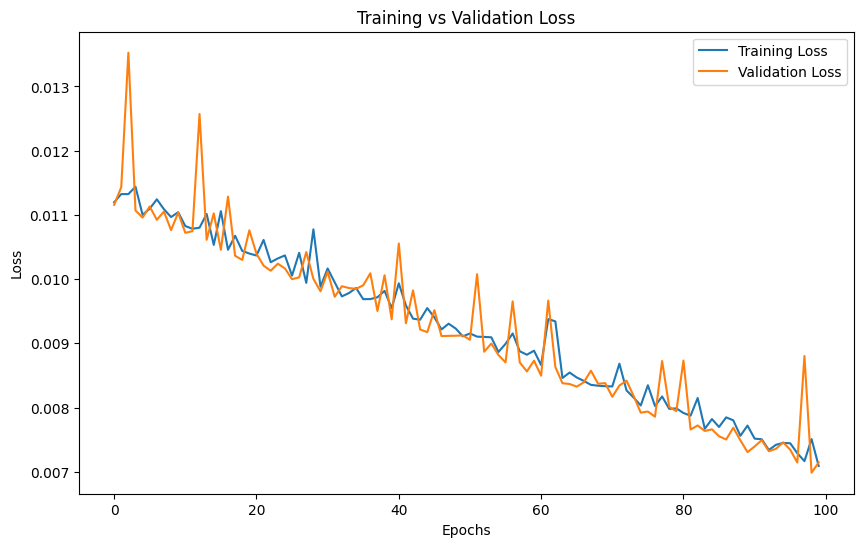

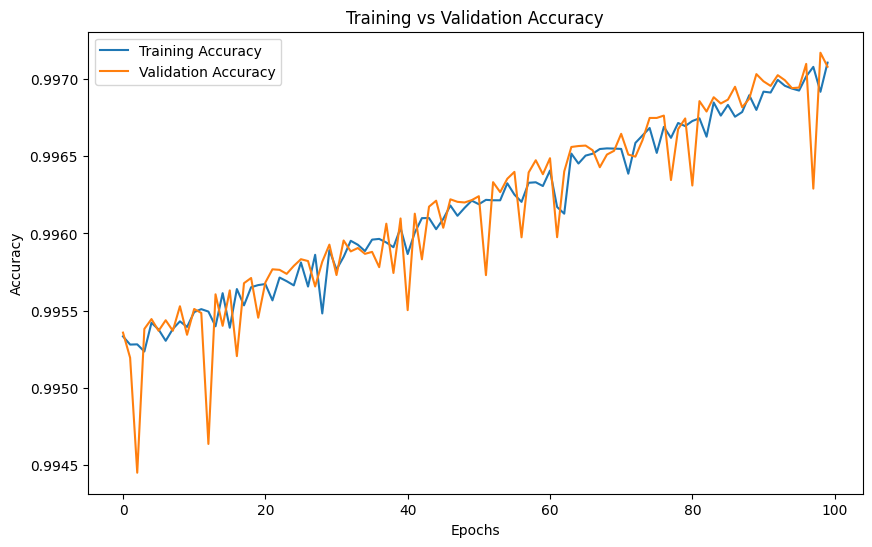

In [ ]:
import matplotlib.pyplot as plt
import json

# Save findings after model training
def save_training_findings(history, output_file):
    findings = {
        'final_validation_loss': history.history['val_loss'][-1],
        'final_validation_accuracy': history.history['val_accuracy'][-1],
        'training_loss': history.history['loss'],
        'training_accuracy': history.history['accuracy'],
        'validation_loss': history.history['val_loss'],
        'validation_accuracy': history.history['val_accuracy']
    }

    # Save findings to a JSON file
    with open(output_file, 'w') as f:
        json.dump(findings, f, indent=4)

    print(f"Findings saved to {output_file}")

# Call the function to save metrics
output_file = '/content/drive/MyDrive/training_findings.json'
save_training_findings(history, output_file)

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/training_vs_validation_loss.png')
plt.show()

# Plot training vs validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/training_vs_validation_accuracy.png')
plt.show()


In [ ]:
import numpy as np
import os

# Directory where ground truth masks are stored
ground_truth_dir = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test44/train/masks/'
y_true = []

# Load all ground truth masks
for file in sorted(os.listdir(ground_truth_dir)):
    mask = np.load(os.path.join(ground_truth_dir, file))
    y_true.append(mask)

y_true = np.array(y_true)  # Convert to numpy array
print("Loaded ground truth masks:", y_true.shape)


Loaded ground truth masks: (67, 128, 128, 128)


In [ ]:
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/brats_3d_u_net.h5')

# Directory where validation images are stored
val_img_dir = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test44/val/images/'
y_pred = []

# Predict on validation images
for file in sorted(os.listdir(val_img_dir)):
    image = np.load(os.path.join(val_img_dir, file))
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    prediction = np.argmax(prediction, axis=-1)  # Convert probabilities to class labels
    y_pred.append(prediction.squeeze())  # Remove batch dimension

y_pred = np.array(y_pred)
print("Generated predictions:", y_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Generated predictions: (23, 128, 128, 128)


In [ ]:
np.save('/content/drive/MyDrive/y_true.npy', y_true)
np.save('/content/drive/MyDrive/y_pred.npy', y_pred)
print("Saved ground truth and predictions.")


Saved ground truth and predictions.


In [ ]:
import numpy as np
import tensorflow as tf
import os

def calculate_metrics(y_true, y_pred, num_classes=4, class_names=None):
    """
    Calculate Specificity, Sensitivity, and Dice Similarity Coefficient (DSC).
    """
    metrics_dict = {}
    dice_scores = []
    sensitivities = []
    specificities = []  # Add a list to store specificities

    for class_idx in range(num_classes):
        true_positive = np.sum((y_pred == class_idx) & (y_true == class_idx))
        false_positive = np.sum((y_pred == class_idx) & (y_true != class_idx))
        false_negative = np.sum((y_pred != class_idx) & (y_true == class_idx))
        true_negative = np.sum((y_pred != class_idx) & (y_true != class_idx))

        # Sensitivity (Recall)
        sensitivity = true_positive / (true_positive + false_negative + 1e-8)
        sensitivities.append(sensitivity)

        # Specificity
        specificity = true_negative / (true_negative + false_positive + 1e-8)
        specificities.append(specificity)  # Append specificity to the list

        # Dice Similarity Coefficient (DSC)
        dsc = (2 * true_positive) / (2 * true_positive + false_positive + false_negative + 1e-8)
        dice_scores.append(dsc)

        # Use class_names or generate class labels if not provided
        class_name = class_names[class_idx] if class_names else f'class_{class_idx}'
        metrics_dict[class_name] = {
            'Specificity': specificity,
            'Sensitivity': sensitivity,
            'DSC': dsc
        }

    # Overall metrics
    overall_metrics = {
        'Mean_DSC': np.mean(dice_scores),
        'Mean_Sensitivity': np.mean(sensitivities),
        'Mean_Specificity': np.mean(specificities)  # Calculate mean specificity directly
    }

    return metrics_dict, overall_metrics

# Paths to model and ground truth
model_path = '/content/drive/MyDrive/brats_3d_u_net.h5'
ground_truth_path = '/content/drive/MyDrive/y_true.npy'
val_img_dir = '/content/drive/MyDrive/archive (9)/BraTS2020_TrainingData/numpy_data_test44/val/images/'

# Load the ground truth
y_true = np.load(ground_truth_path)

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Generate predictions
y_pred = []
for file in sorted(os.listdir(val_img_dir)):
    image = np.load(os.path.join(val_img_dir, file))
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    prediction = np.argmax(prediction, axis=-1)  # Convert probabilities to class labels
    y_pred.append(prediction.squeeze())  # Remove batch dimension
y_pred = np.array(y_pred)

# Align the shapes of y_true and y_pred
min_samples = min(y_true.shape[0], y_pred.shape[0])
y_true = y_true[:min_samples]
y_pred = y_pred[:min_samples]

# Class names
class_names = ['T1', 'T2', 'T1ce', 'FLAIR']

# Calculate metrics
metrics, overall_metrics = calculate_metrics(y_true, y_pred, num_classes=4, class_names=class_names)

# Print results
for class_name, values in metrics.items():
    print(f"Metrics for {class_name}:")
    for metric, value in values.items():
        print(f"  {metric}: {value:.4f}")
    print()

# Print overall metrics
print("Overall Metrics:")
for metric, value in overall_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Calculate and print overall validation loss and accuracy
def calculate_overall_loss_accuracy(y_true, y_pred):
    """
    Calculate overall validation loss and accuracy.
    """
    # Validation loss (example: simple difference measure)
    overall_loss = np.mean((y_true - y_pred) ** 2)

    # Validation accuracy
    overall_accuracy = np.mean(y_true == y_pred)

    return overall_loss, overall_accuracy

# Compute overall loss and accuracy
overall_loss, overall_accuracy = calculate_overall_loss_accuracy(y_true, y_pred)

print(f"Overall Validation Loss: {overall_loss:.4f}")
print(f"Overall Validation Accuracy: {overall_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Metrics for T1:
  Specificity: 0.9833
  Sensitivity: 0.9993
  DSC: 0.9994

Metrics for T2:
  Specificity: 0.9988
  Sensitivit